In [14]:
import Diagram as pc
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from scipy import stats

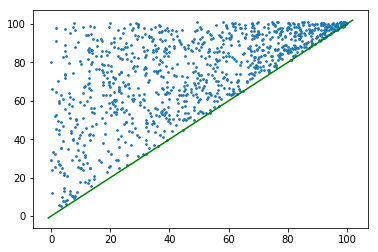

In [3]:
n=1000
for k in range(100):
    X = np.random.uniform(0,100, n)
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = np.random.uniform(X[i], 101,1)
Dgm = pd.DataFrame(np.stack([X,Y], axis=1))
Dgm = pc.Diagram(Dgm)        
Dgm.plot()

In [5]:
def custom_curve_at_t(Dgm,fun,stat,t):
    Birth = Dgm.Birth
    Death = Dgm.Death
    if Dgm.infinitedeath == -1:
        if Dgm.globalmaxdeath is None:
            Death[Death<0] =Death[Death<0] + np.max(Dgm.Death) + 2
        else:
            Death[Death<0] = Death[Death<0] +2 + Dgm.globalmaxdeath
    else:
        if Dgm.globalmaxdeath is None:
            Death[Death==Dgm.infinitedeath] =Death[Death==Dgm.infinitedeath] + np.max(Dgm.Death) + 2
        else:
            Death[Death==Dgm.infinitedeath] = Death[Death==Dgm.infinitedeath] +2 + Dgm.globalmaxdeath
    tmpBirth= Birth[(t>=Dgm.Birth) &(t<Dgm.Death)]
    tmpDeath =Death[(t>=Dgm.Birth) &(t<Dgm.Death)]
    values = []
    for i in range(tmpBirth.shape[0]):
        values.append(fun(Dgm,tmpBirth[i], tmpDeath[i], t))
    return stat(values)
def custom_curve(Dgm,fun, stat, meshstart, meshstop, numberinmesh):
    L = np.array([])
    x = np.linspace(meshstart, meshstop, numberinmesh)
    for t in x:
        L = np.append(L, custom_curve_at_t(Dgm, fun, stat, t))
    return L
def fun(Dgm,b,d,t):
    return d-b
def lifecurve(Dgm, meshstart, meshstop, num_in_mesh):
        #Produces the life curve of the diagram
        #@param meshstart: The lowest value at which to begin the curve
        #@param meshstop: the highest value at which to stop the curve
        #@param num_in_mesh: The number of evenly spaced points between meshstart and meshstop at which to compute the curve values
    Birth = Dgm.Birth
    Death = Dgm.Death
    if Dgm.infinitedeath is None:
        if Dgm.globalmaxdeath is None:
            Death[Death<0] =Death[Death<0] + np.max(Dgm.Death) + 2
        else:
            Death[Death<0] = Death[Death<0] +2 + Dgm.globalmaxdeath
    else:
        if Dgm.globalmaxdeath is None:
            Death[Death==Dgm.infinitedeath] =Death[Death==Dgm.infinitedeath] + np.max(Dgm.Death) + 2
        else:
            Death[Death==Dgm.infinitedeath] = Death[Death==Dgm.infinitedeath]+2 + Dgm.globalmaxdeath
    bins = np.linspace(meshstart, meshstop, num_in_mesh)
    #centers = (bins[1:]+bins[:-1])/2
    tmp = np.zeros([Dgm.shape[0], num_in_mesh])
    FUN = Death - Birth
    for i in range(Dgm.shape[0]):
        x = np.array([Birth[i],Death[i]])
        res =np.where(np.digitize(bins, x, right=False)==1)[0]
        if len(res) !=0:
            tmp[i, res[0]:res[len(res)-1]+1] = FUN[i]
    curve = tmp.sum(axis = 0)
    return curve


In [16]:
def smooth_life(Dgm, meshstart, meshstop, num_in_mesh):
        #Produces the gaussian life curve of the diagram
        #@param meshstart: The lowest value at which to begin the curve
        #@param meshstop: the highest value at which to stop the curve
        #@param num_in_mesh: The number of evenly spaced points between meshstart and meshstop at which to compute the curve values
    Birth = Dgm.Birth
    Death = Dgm.Death
    if Dgm.infinitedeath is None:
        if Dgm.globalmaxdeath is None:
            Death[Death<0] =Death[Death<0] + np.max(Dgm.Death) + 2
        else:
            Death[Death<0] = Death[Death<0] +2 + Dgm.globalmaxdeath
    else:
        if Dgm.globalmaxdeath is None:
            Death[Death==Dgm.infinitedeath] =Death[Death==Dgm.infinitedeath] + np.max(Dgm.Death) + 2
        else:
            Death[Death==Dgm.infinitedeath] = Death[Death==Dgm.infinitedeath]+2 + Dgm.globalmaxdeath
    T = np.linspace(meshstart, meshstop, num_in_mesh)

    Death[Death < 0] = 255
    Life = Death - Birth
    B = np.matmul(np.array(Birth).reshape(-1,1),np.ones([1,num_in_mesh]))
    De = np.matmul(np.array(Death).reshape(-1,1),np.ones([1,num_in_mesh]))
    L = np.matmul(np.array(Life).reshape(-1,1),np.ones([1,num_in_mesh]))
    return np.sum(stats.norm.cdf((T-B)/L)*(1-stats.norm.cdf((T-De)/L)), axis=0)
def smooth_midlife(Dgm):
    Dgm['Death'][Dgm['Death'] < 0] = 255
    Life = Dgm.Death + Dgm.Birth
    T = np.matmul(np.ones([Dgm.shape[0],1]),np.arange(256).reshape(1,-1)) 
    B = np.matmul(np.array(Dgm.Birth).reshape(-1,1),np.ones([1,256]))
    De = np.matmul(np.array(Dgm.Death).reshape(-1,1),np.ones([1,256]))
    L = np.matmul(np.array(Life).reshape(-1,1),np.ones([1,256]))
    return np.sum(stats.norm.cdf((T-B)/L)*(1-stats.norm.cdf((T-De)/L)), axis=0)
def smooth_stabilizedlife(Dgm):
    Dgm['Death'][Dgm['Death'] < 0] = 255
    Life = (Dgm.Death - Dgm.Birth)
    T = np.matmul(np.ones([Dgm.shape[0],1]),np.arange(256).reshape(1,-1)) 
    B = np.matmul(np.array(Dgm.Birth).reshape(-1,1),np.ones([1,256]))
    De = np.matmul(np.array(Dgm.Death).reshape(-1,1),np.ones([1,256]))
    L = np.matmul(np.array(Life/np.sum(Life)).reshape(-1,1),np.ones([1,256]))
    return np.sum(stats.norm.cdf((T-B)/L)*(1-stats.norm.cdf((T-De)/L)), axis=0)

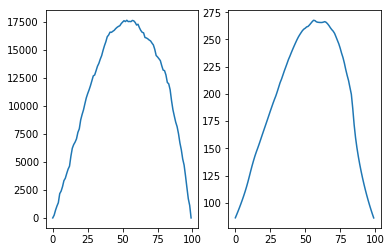

In [23]:
N = 100
plt.subplot(121)
plt.plot(range(N),lifecurve(Dgm, 0,101,N))
plt.subplot(122)
plt.plot(range(N), smooth_life(Dgm, -10, 120, N))

In [10]:
Dgm

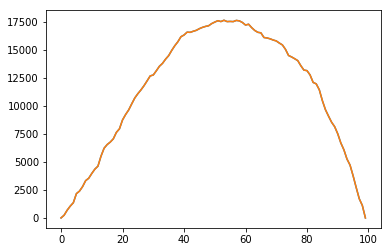

In [6]:
N = 100
plt.plot(range(N),lifecurve(Dgm, 0,101,N))
plt.plot(range(N), Dgm.custom_curve(fun, np.sum, 0, 101, 100))

In [11]:
Dgm

In [4]:
meshstart = 0
meshstop = 100
num_in_mesh = 100
Birth = Dgm.Birth
Death = Dgm.Death
if Dgm.infinitedeath is None:
    if Dgm.globalmaxdeath is None:
        Death[Death<0] =Death[Death<0] + np.max(Dgm.Death) + 2
    else:
        Death[Death<0] = Death[Death<0] +2 + Dgm.globalmaxdeath
else:
    if Dgm.globalmaxdeath is None:
        Death[Death==Dgm.infinitedeath] =Death[Death==Dgm.infinitedeath] + np.max(Dgm.Death) + 2
    else:
        Death[Death==Dgm.infinitedeath] = Death[Death==Dgm.infinitedeath]+2 + Dgm.globalmaxdeath
bins = np.linspace(meshstart, meshstop, num_in_mesh)
#centers = (bins[1:]+bins[:-1])/2
tmp = np.zeros([Dgm.shape[0], num_in_mesh])
FUN = Death - Birth
for i in range(Dgm.shape[0]):
    x = np.array([Birth[i],Death[i]])
    res =np.where(np.digitize(bins, x, right=False)==1)[0]
    if len(res) !=0:
        tmp[i, res[0]:res[len(res)-1]+1] = FUN[i]
curve = tmp.sum(axis = 0)

In [34]:
curve == lifecurve(Dgm, 0, 100, 100)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [13]:
x = np.array([Dgm.Birth[20],Dgm.Death[20]])
res =np.digitize(bins, x)

In [29]:
np.where(res==1)

(array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 66, 67, 68, 69], dtype=int64),)

In [15]:
Time = np.array([])
N = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000,500000,1000000]
for n in N:
    times = np.array([])
    for k in range(100):
        X = np.random.uniform(0,100, n)
        Y = np.zeros(n)
        for i in range(n):
            Y[i] = np.random.uniform(X[i], 101,1)
        Dgm = pd.DataFrame(np.stack([X,Y], axis=1))
        Dgm = Diagram.Diagram(Dgm)
        start = time()
        Dgm.multilifeentropycurve(0,101,1000)
        times = np.append(times, time()-start)
    print(times.mean())
    Time = np.append(Time, times.mean())

0.00013962507247924805
0.0002892160415649414
0.00041887521743774416
0.0035622572898864747
0.006728284358978272
0.03373889207839966
0.0677557373046875
0.37628204822540284
0.7185398650169372
3.4154610586166383
6.735299682617187


In [24]:
(Time[10]-Time[5])/(N[10]-N[5])

6.735236975415866e-06

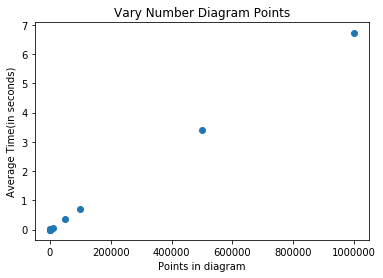

In [29]:
N = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000,500000,1000000]
plt.scatter(N, Time)
plt.title("Vary Number Diagram Points")
plt.xlabel("Points in diagram")
plt.ylabel("Average Time(in seconds)")
plt.savefig("VaryPoints.png")

In [14]:
Time2 = np.array([])
N = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
for n in N:
    times = np.array([])
    for k in range(100):
        X = np.random.uniform(0,100, 10000)
        Y = np.zeros(10000)
        for i in range(10000):
            Y[i] = np.random.uniform(X[i], 101,1)
        Dgm = pd.DataFrame(np.stack([X,Y], axis=1))
        Dgm = Diagram.Diagram(Dgm)
        start = time()
        Dgm.multilifeentropycurve(0,101,n)
        times = np.append(times, time()-start)
    print(times.mean())
    Time2 = np.append(Time2, times.mean())

0.02142773389816284
0.02325319290161133
0.026341731548309325
0.045365338325500486
0.06760527610778809
0.23989055395126344
0.4519569635391235
2.1408381915092467


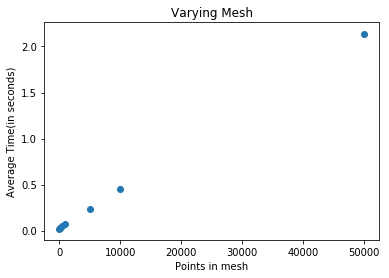

In [30]:
N = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
plt.scatter(N, Time2)
plt.title("Varying Mesh")
plt.xlabel("Points in mesh")
plt.ylabel("Average Time(in seconds)")
plt.savefig("VaryMesh.png")

In [18]:
(Time[5]-Time[4])/(N[5]-N[4]) - (Time[2]-Time[1])/(N[2]-N[1]) 

3.1261375480228003e-06